In [26]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")
import plotly.express as px

## Setting max displayed rows to 500, in order to display the full output of any command
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Setting to avoid scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# pour que les valeurs infinies soient considérées aussi comme des NaN :
pd.options.mode.use_inf_as_na = True

# sklearn
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

In [2]:
# pipelines
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
# preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
# feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
# models
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
# model selection
from sklearn.model_selection import RandomizedSearchCV
# scores
from sklearn.model_selection import cross_val_predict, cross_val_score

# Préparation du dataset

In [3]:
import datetime
def calcul_ratios(df):
    df["Credit client"] = (df['Clients et comptes rattachés (3) (net) (BXNET) 2018 (€)']*365)/(df["Chiffre d'affaires net (Total) (FL) 2018 (€)"]*1.2)

    df["Credit Fournisseurs"] = df['Dettes fournisseurs et comptes rattachés (DX) 2018 (€)']*365/(
        (df['Achats de marchandises (y compris droits de douane) (FS) 2018 (€)'] 
        + df['Achats de matières premières et autres approvisionnements (y compris droits de douane) (FU) 2018 (€)'] 
        + df['Autres achats et charges externes (3) (6 bis) (FW) 2018 (€)']
        )*1.2)

    df["Rotation_stocks"] = ( df['Matières premières, approvisionnements (net) (BLNET) 2018 (€)'] + 
             + df['En cours de production de biens (net) (BNNET) 2018 (€)'] 
             + df['En cours de production de services (net) (BPNET) 2018 (€)']
             + df['Produits intermédiaires et finis (net) (BRNET) 2018 (€)']
             + df['Marchandises (net) (BTNET) 2018 (€)'])*365 / (
                df["Chiffre d'affaires net (Total) (FL) 2018 (€)"]  
                - df["1 - RESULTAT D'EXPLOITATION (I - II) (GG) 2018 (€)"])

    df["BFR"] = (
        df['TOTAL (III) (net) (CJNET) 2018 (€)']
        + df['Valeurs mobilières de placement (net) (CDNET) 2018 (€)']
        + df['Disponibilités (net) (CFNET) 2018 (€)']
        - df['Avances et acomptes reçus sur commandes en cours (DW) 2018 (€)']
        - df['Dettes fournisseurs et comptes rattachés (DX) 2018 (€)']
        - df['Dettes fiscales et sociales (DY) 2018 (€)']
        - df['Dettes sur immobilisations et comptes rattachés (DZ) 2018 (€)']
        - df['Autres dettes (EA) 2018 (€)']
        - df["Produits constatés d'avance (EB) 2018 (€)"])


    df["BFRE"] = (
                df['Matières premières, approvisionnements (net) (BLNET) 2018 (€)']
                 + df['En cours de production de services (net) (BPNET) 2018 (€)']
                 + df['En cours de production de biens (net) (BNNET) 2018 (€)']
                 + df['Produits intermédiaires et finis (net) (BRNET) 2018 (€)']
                 + df['Marchandises (net) (BTNET) 2018 (€)']
                 + df['Avances et acomptes versés sur commandes (net) (BVNET) 2018 (€)']
                 + df['Clients et comptes rattachés (3) (net) (BXNET) 2018 (€)']
                - df['Avances et acomptes reçus sur commandes en cours (DW) 2018 (€)']
                - df['Dettes fournisseurs et comptes rattachés (DX) 2018 (€)']
                - df['Dettes fiscales et sociales (DY) 2018 (€)']
                - df['Autres dettes (EA) 2018 (€)']
                 )

    df["Endettement total"] = (df['Autres emprunts obligataires (DT) 2018 (€)']
                 + df['Emprunts obligataires convertibles (DS) 2018 (€)']
                 + df['Emprunts et dettes auprès des établissements de crédit (5) (DU) 2018 (€)']
                 + df['Emprunts et dettes financières divers (DV) 2018 (€)']
                - df['(5)\xa0Dont concours bancaires courants, et soldes créditeurs de banques et CCP (EH) 2018 (€)'])

    df["CAF"] = (df['3 - RESULTAT COURANT AVANT IMPOTS (I - II + III - IV + V - VI) (GW) 2018 (€)']
                - df['Reprises sur amortissements et provisions, transferts de charges (9) (FP) 2018 (€)']
                + df["Dotations d'exploitation sur immobilisations (dotations aux amortissements) (GA) 2018 (€)"]
                + df["Dotations d'exploitation sur immobilisations (dotations aux provisions) (GB) 2018 (€)"]
                + df["Dotations d'exploitation sur actif circulant (dotations aux provisions) (GC) 2018 (€)"]
                + df["Dotations d'exploitation pour risques et charges (dotations aux provisions) (GD) 2018 (€)"]
                - df['Reprises sur provisions & transferts de charges (GM) 2018 (€)']
                + df['Dotations financières aux amortissements et provisions (GQ) 2018 (€)']
                - df["Participation des salariés aux résultats de l'entreprise (HJ) 2018 (€)"]
                - df['Impôts sur les bénéfices (HK) 2018 (€)'])

    df["Capacite de remboursement"] = df["Endettement total"] / df["CAF"]


    df["Ressources durables"] = (df['TOTAL (I) (DL) 2018 (€)']
                 + df['TOTAL(II) (DO) 2018 (€)']
                 + df['TOTAL (III) (DR) 2018 (€)']
                 + df['Autres emprunts obligataires (DT) 2018 (€)']
                 + df['Emprunts obligataires convertibles (DS) 2018 (€)']
                 + df['Emprunts et dettes auprès des établissements de crédit (5) (DU) 2018 (€)']
                 + df['Emprunts et dettes financières divers (DV) 2018 (€)']
                 - df['(5)\xa0Dont concours bancaires courants, et soldes créditeurs de banques et CCP (EH) 2018 (€)']
                 - df['Capital souscrit non appelé (I) (AA) 2018 (€)'])


    df["FRNG"] = (df["Ressources durables"]   
                 + df['Ecarts de conversion passif (V) (ED) 2018 (€)']
                 - df['Primes de remboursement des obligations (CM) 2018 (€)']
                 - df['Ecarts de conversion actif (CN) 2018 (€)']
                 + df['TOTAL (II) (net) (BJNET) 2018 (€)'])

    df["Taux endettement"] = df["Endettement total"] / df["Ressources durables"]

    df["Rentabilite financiere"] = (df["RESULTAT DE L'EXERCICE (bénéfice ou perte) (DI) 2018 (€)"] 
                                    / (df['TOTAL (I) (DL) 2018 (€)'] 
                                       - df['Capital souscrit non appelé (I) (AA) 2018 (€)']))

    df["EBE"] = (df["Chiffre d'affaires net (Total) (FL) 2018 (€)"]
                + df["Subventions d'exploitation (FO) 2018 (€)"]
                + df['Production stockée (FM) 2018 (€)']
                + df['Production immobilisée (FN) 2018 (€)']
                - df['Achats de marchandises (y compris droits de douane) (FS) 2018 (€)']
                - df['Variation de stock (marchandises) (FT) 2018 (€)']
                - df['Achats de matières premières et autres approvisionnements (y compris droits de douane) (FU) 2018 (€)']
                - df['Variation de stock (matières premières et approvisionnements) (FV) 2018 (€)']
                - df['Autres achats et charges externes (3) (6 bis) (FW) 2018 (€)']
                - df['Impôts, taxes et versements assimilés (FX) 2018 (€)']
                - df['Salaires et traitements (FY) 2018 (€)']
                - df['Charges sociales (10) (FZ) 2018 (€)']
                + df['(3)\xa0Dont Crédit-bail mobilier (HP) 2018 (€)']
                + df['(3)\xa0Dont Crédit-bail immobilier (HQ) 2018 (€)']
                )

    df["VA"] = (df["EBE"] 
                - df["Subventions d'exploitation (FO) 2018 (€)"]
                + df['Impôts, taxes et versements assimilés (FX) 2018 (€)']
                + df['Salaires et traitements (FY) 2018 (€)']
                + df['Charges sociales (10) (FZ) 2018 (€)'])

    df["Liquidite generale"] = ((df['TOTAL (III) (net) (CJNET) 2018 (€)']
                               - df["Charges constatées d'avance (3) (net) (CHNET) 2018 (€)"])
                               / (df['Avances et acomptes reçus sur commandes en cours (DW) 2018 (€)']
                                 + df['Dettes fournisseurs et comptes rattachés (DX) 2018 (€)']
                                 + df['Dettes fiscales et sociales (DY) 2018 (€)']
                                 + df['Dettes sur immobilisations et comptes rattachés (DZ) 2018 (€)']
                                 + df['Autres dettes (EA) 2018 (€)']
                                 + df['(5)\xa0Dont concours bancaires courants, et soldes créditeurs de banques et CCP (EH) 2018 (€)']))


    df["Liquidite reduite"] = (
        (
            (df['TOTAL (III) (net) (CJNET) 2018 (€)']
                               - df["Charges constatées d'avance (3) (net) (CHNET) 2018 (€)"]
            )
                               - (
                                   df['Matières premières, approvisionnements (net) (BLNET) 2018 (€)']
                                 + df['En cours de production de services (net) (BPNET) 2018 (€)']
                                 + df['En cours de production de biens (net) (BNNET) 2018 (€)']
                                 + df['Produits intermédiaires et finis (net) (BRNET) 2018 (€)']
                                 + df['Marchandises (net) (BTNET) 2018 (€)']
                                 )
        ) 
                                / (
                                    df['Avances et acomptes reçus sur commandes en cours (DW) 2018 (€)']
                                 + df['Dettes fournisseurs et comptes rattachés (DX) 2018 (€)']
                                 + df['Dettes fiscales et sociales (DY) 2018 (€)']
                                 + df['Dettes sur immobilisations et comptes rattachés (DZ) 2018 (€)']
                                 + df['Autres dettes (EA) 2018 (€)']
                                 + df['(5)\xa0Dont concours bancaires courants, et soldes créditeurs de banques et CCP (EH) 2018 (€)']
                                    )
                                )

    df["Taux ressources propres"] = ((df['TOTAL (I) (DL) 2018 (€)'] 
                                     - df['Capital souscrit non appelé (I) (AA) 2018 (€)'])
                                    / df['TOTAL GENERAL (I à V) (EE) 2018 (€)'])

    #df["CA par employe"] = gérer les 0

    df["Rentabilite des capitaux propres"] = (df["RESULTAT DE L'EXERCICE (bénéfice ou perte) (DI) 2018 (€)"]
                                             / (df['TOTAL (I) (DL) 2018 (€)']
                                                + df['TOTAL(II) (DO) 2018 (€)']
                                                - df['Capital souscrit non appelé (I) (AA) 2018 (€)']))

    df["Autonomie financiere"] = ((df['TOTAL (I) (DL) 2018 (€)']
                                                + df['TOTAL(II) (DO) 2018 (€)']
                                                - df['Capital souscrit non appelé (I) (AA) 2018 (€)'])
                                  / df['TOTAL GENERAL (I à V) (EE) 2018 (€)'])

    df["Poids interets"] = (df['Intérêts et charges assimilées (GR) 2018 (€)'] 
                            / df["1 - RESULTAT D'EXPLOITATION (I - II) (GG) 2018 (€)"])

    df["Taux EBE"] = (df["EBE"]
                      / df["Chiffre d'affaires net (Total) (FL) 2018 (€)"])

    df["Taux VA"] = (df["VA"]
                      / df["Chiffre d'affaires net (Total) (FL) 2018 (€)"])

    df["Taux Rentabilite"] = (df["RESULTAT DE L'EXERCICE (bénéfice ou perte) (DI) 2018 (€)"]
                             / df["Chiffre d'affaires net (Total) (FL) 2018 (€)"])

    df["Poids dettes fiscales"] = ((df['Sécurité sociale et autres organismes sociaux - Montant brut (8D) 2018 (€)']
                                   + df['Impôts sur les bénéfices - Montant brut (8E) 2018 (€)']
                                   + df['T.V.A. - Montant brut (VW) 2018 (€)'])
                                   / df["Chiffre d'affaires net (Total) (FL) 2018 (€)"])


    df["Tresorerie"] = df["FRNG"] - df["BFR"]
    
    df["Taux augmentation endettement CT"] = (df['Emprunts souscrits en cours d’exercice - à 1 an au plus (VJ2) 2018 (€)']
                                         / df['TOTAL GENERAL (I à V) (EE) 2018 (€)'])

    
    df["Croissance CA"] = ((df["Chiffre d'affaires net (Total) (FL) 2018 (€)"] 
                       - df["Chiffre d'affaires net (Total) (FL) 2017 (€)"]) 
                        / df["Chiffre d'affaires net (Total) (FL) 2017 (€)"]) 
    
    df["Apport en comptes courants"] = (df["dont comptes courants d'associés de l'exercice N (EA2) 2018 (€)"] 
                       - df["dont comptes courants d'associés de l'exercice N (EA2) 2017 (€)"]) 
                      
    df["Date de création"] = pd.to_datetime(df["Date de création"])
    df["Age entreprise"] = ((datetime.datetime(2019,12,31) - df["Date de création"])/np.timedelta64(1, 'M'))
    df["Age entreprise"] = df["Age entreprise"].astype(int)
    
    return df

In [4]:
def suppr_nulls_nans(df):
    # suppression des entreprises avec CA null
    df = df[df["Chiffre d'affaires net (Total) (FL) 2018 (€)"] > 0]
    # suppression des colonnes avec plus de 12% de NaN (sauf tranche d'effectif)
    cols_null_to_drop = ["Procédures collectives (type)", 
                         "Procédures collectives (date)", 
                         "Croissance CA", 
                         "Apport en comptes courants", 
                         "dont comptes courants d'associés de l'exercice N (EA2) 2017 (€)", 
                         "Chiffre d'affaires net (Total) (FL) 2017 (€)"]
    df = df.drop(cols_null_to_drop, axis=1)
    # passage des valeurs infinies en nan
    df = df.replace([np.inf, -np.inf], np.nan)
    return df

In [5]:
def merge_naf(df, naf_path):
    df_naf = pd.read_excel(naf_path, header=[1])
    df_naf = df_naf.drop(["Unnamed: 10", "Unnamed: 11", "Unnamed: 12", "Unnamed: 13", "Unnamed: 14", "Unnamed: 15",
            "Unnamed: 16", "Unnamed: 17", "Unnamed: 18", "Unnamed: 19", "Unnamed: 20", "Unnamed: 21", "Unnamed: 22"], axis=1)
    df_naf = df_naf.rename(columns={'Unnamed: 1':'Descriptif A 732'})
    # Step 1 - suppression des points dans la colonne A 732
    # pour avoir le même format que dans les données d'entreprises
    for row in range(df_naf.shape[0]):
        df_naf.loc[row,'A 732'] = df_naf.loc[row,'A 732'].replace('.', '')
    # Step 2 - Join avec le dataset d'entreprises 
    # (pour la mise en DB, il faudra créér deux tables et faire les joins dans la requête SQL)
    df_merged = pd.merge(df, df_naf, how = 'left', left_on = df['Code APE'], right_on = df_naf['A 732'])
    df_merged = df_merged.drop(['key_0'], axis=1)
    assert df_merged.shape[0]==df.shape[0]
    assert df_merged.shape[1]==df.shape[1]+df_naf.shape[1]
    return df_merged, df_naf

In [6]:
# no longer used
def effectif_encoder(df):
    dic_effectif = { "0 salarié pendant l'année" : 0
                , "0 salarié à la fin de l'année" : 1
                , "De 1 à 2 salariés" : 2
                , "De 3 à 5 salariés" : 3
                , "De 6 à 9 salariés" : 4
                , "De 10 à 19 salariés" : 5
                , "De 20 à 49 salariés" : 6
                , "De 50 à 99 salariés" : 7
                , "De 100 à 199 salariés" : 8
                , "De 200 à 249 salariés" : 9
                , "De 250 à 499 salariés" : 10
                , "De 500 à 999 salariés" : 11
                , "De 1000 à 1999 salariés" : 12
                , "De 2000 à 4999 salariés" : 13 
    }
    df["Tranche effectifs"] = df["Tranche effectifs"].map(dic_effectif)
    return df

In [7]:
# no longer used
def encode_naf21(df):
    dict_naf21 = {'C':0,
                  'E':1,
                  'P':2,
                  'H':3,
                  'F':4,
                  'I':5,
                  'R':6,
                  'G':7,
                  'N':8,
                  'J':9,
                  'S':10,
                  'Q':11,
                  'M':12,
                  'K':13,
                  'A':14,
                  'L':15,
                  'D':16,
                  'O':17,
                  'B':18
    }
    df["A 21 encoded"] = df["A 21"].map(dict_naf21)
    return df

In [8]:
def remove_useless_cols(df):
    useless_cols = [
        "Dénomination",
        "Tranche effectifs",
        "Code APE",
        "Ville",
        "Emprunts remboursés en cours d’exercice (VK) 2018 (€)",
        "Descriptif A 732",
        "A 732",
        "A 615",
        "A 272",
        "A 129",
        "A 88",
        "A 64",
        "A 38",
        "A 10",
        "SIREN",
        "SIRET",
        "Code postal",
        "Emprunts souscrits en cours d’exercice - à 1 an au plus (VJ2) 2018 (€)",
        "Emprunts souscrits en cours d’exercice - à plus d'un an et 5 ans au plus (VJ3) 2018 (€)",
        "Emprunts souscrits en cours d’exercice - à plus de 5 ans (VJ4) 2018 (€)"
    ]
    
    df = df.drop(useless_cols, axis=1)
    return df

In [9]:
def count_outliers(df, col):
    mean = np.mean(df[col], axis=0)
    sd = np.std(df[col], axis=0)
    minimum = mean - 20 * sd
    maximum = mean + 20 * sd
    df_outliers = df.loc[(df[col] <= minimum) | (df[col] >= maximum)]
    return df_outliers.shape[0]

def remove_outliers(df, col):
    mean = np.mean(df[col], axis=0)
    sd = np.std(df[col], axis=0)
    minimum = mean - 20 * sd
    maximum = mean + 20 * sd
    df = df.loc[(df[col] > minimum) & (df[col] < maximum)]
    return df

In [10]:
def apply_categorical_dtypes(df):
    df = df.astype({"Catégorie juridique (Niveau II)" : 'category', 
                            'A 21' : 'category'})
    return df

In [21]:
def get_prepared_df():
    df = pd.read_csv("../data/data_used/total_2018.csv", sep=",")
    df = calcul_ratios(df)
    df = suppr_nulls_nans(df)
    df, df_naf = merge_naf(df, naf_path="../data/data_used/table_NAF2-NA.xls")
    df = remove_useless_cols(df)
    df = apply_categorical_dtypes(df)
    for col in df.select_dtypes(np.number):
        df = remove_outliers(df, col)
    return df

In [22]:
df = get_prepared_df()
df.shape

/Users/marie/.pyenv/versions/3.9.5/envs/simplon/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (87) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


(5740, 116)

# Préparation de la modélisation
## Train test split

In [13]:
#### Train test split

from sklearn.model_selection import train_test_split

# on peut dans un premier temps séparer en 2 le dataset :
trainset, testset = train_test_split(df, test_size=0.2, random_state=0)

# on vérifie que la distribution de la target reste OK dans les test et train set => c'est OK
trainset['default'].value_counts(normalize=True)

testset['default'].value_counts(normalize=True)




0.00000   0.61847
1.00000   0.38153
Name: default, dtype: float64

In [34]:
X = df.drop(["default"], axis=1)
y = df["default"]

In [36]:
X_num = X.select_dtypes(include=np.number)

In [23]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
# la learning curve est indispensable pour identifier l'over ou l'under fitting
# inspirée de machine_lerania
from sklearn.model_selection import learning_curve

def evaluate2(model, X_train, y_train, X_test, y_test):
    
    # on entraine le modèle
    model.fit(X_train, y_train)
    # on fait les predictions
    y_pred = model.predict(X_test)
    
    # on fait la confusion_matrix
    conf = pd.DataFrame(confusion_matrix(y_test, y_pred))
    conf = conf.rename(columns={0: 'Predicted 0',1:'Predicted 1'})
    conf = conf.rename(index={0: 'Actual 0',1:"Actual 1"})
    conf["TOTAL"] = conf["Predicted 0"]+conf["Predicted 1"]
    conf = conf.append(pd.Series(conf.sum(axis=0), name="TOTAL"))

    
    print("__---__ CONFUSION MATRIX __---__")
    print(conf)
    print("\n__---__ CLASSIFICATION REPORT __---__")
    print(classification_report(y_test, y_pred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    # on visualise ca dans un graphique
    plt.figure(figsize=(12, 8))
    # évolu du train_score en fonction du nombre d'échantillons (N)
    # on prend le score_mean car on est en cross-val
    plt.plot(N, (1-train_score.mean(axis=1)), label='train error')
    plt.plot(N, (1-val_score.mean(axis=1)), label='validation error')
    plt.legend()
    # Add title and axis names
    plt.title('LEARNING CURVES')
    plt.xlabel('sample size')
    plt.ylabel('error (1 - F1 score)')

# Exemple d'usage :    
#X1_train = trainset[["A 21 encoded"]]
#y1_train = trainset["default"]
#X1_test = testset[["A 21 encoded"]]
#y1_test = testset["default"]
# model = LogisticRegression()

#evaluate(model)   

# Distribution des features

In [30]:
fig = px.histogram(df, x=df['Dettes fiscales et sociales (DY) 2018 (€)'], color="default", nbins=6000, histnorm='probability density', marginal="box", title="Distribution des dettes fiscales et sociales")
fig.update_traces(opacity=0.6)
fig.show()

# Multicolinéarité

In [14]:
df_numeric = df.select_dtypes(include=np.number)

In [15]:
df_numeric = df_numeric.dropna()

In [23]:
corr = df_numeric.corr()

In [26]:
corr = corr.drop(["Taux augmentation endettement CT"], axis=1)

In [28]:
corr=corr.dropna()

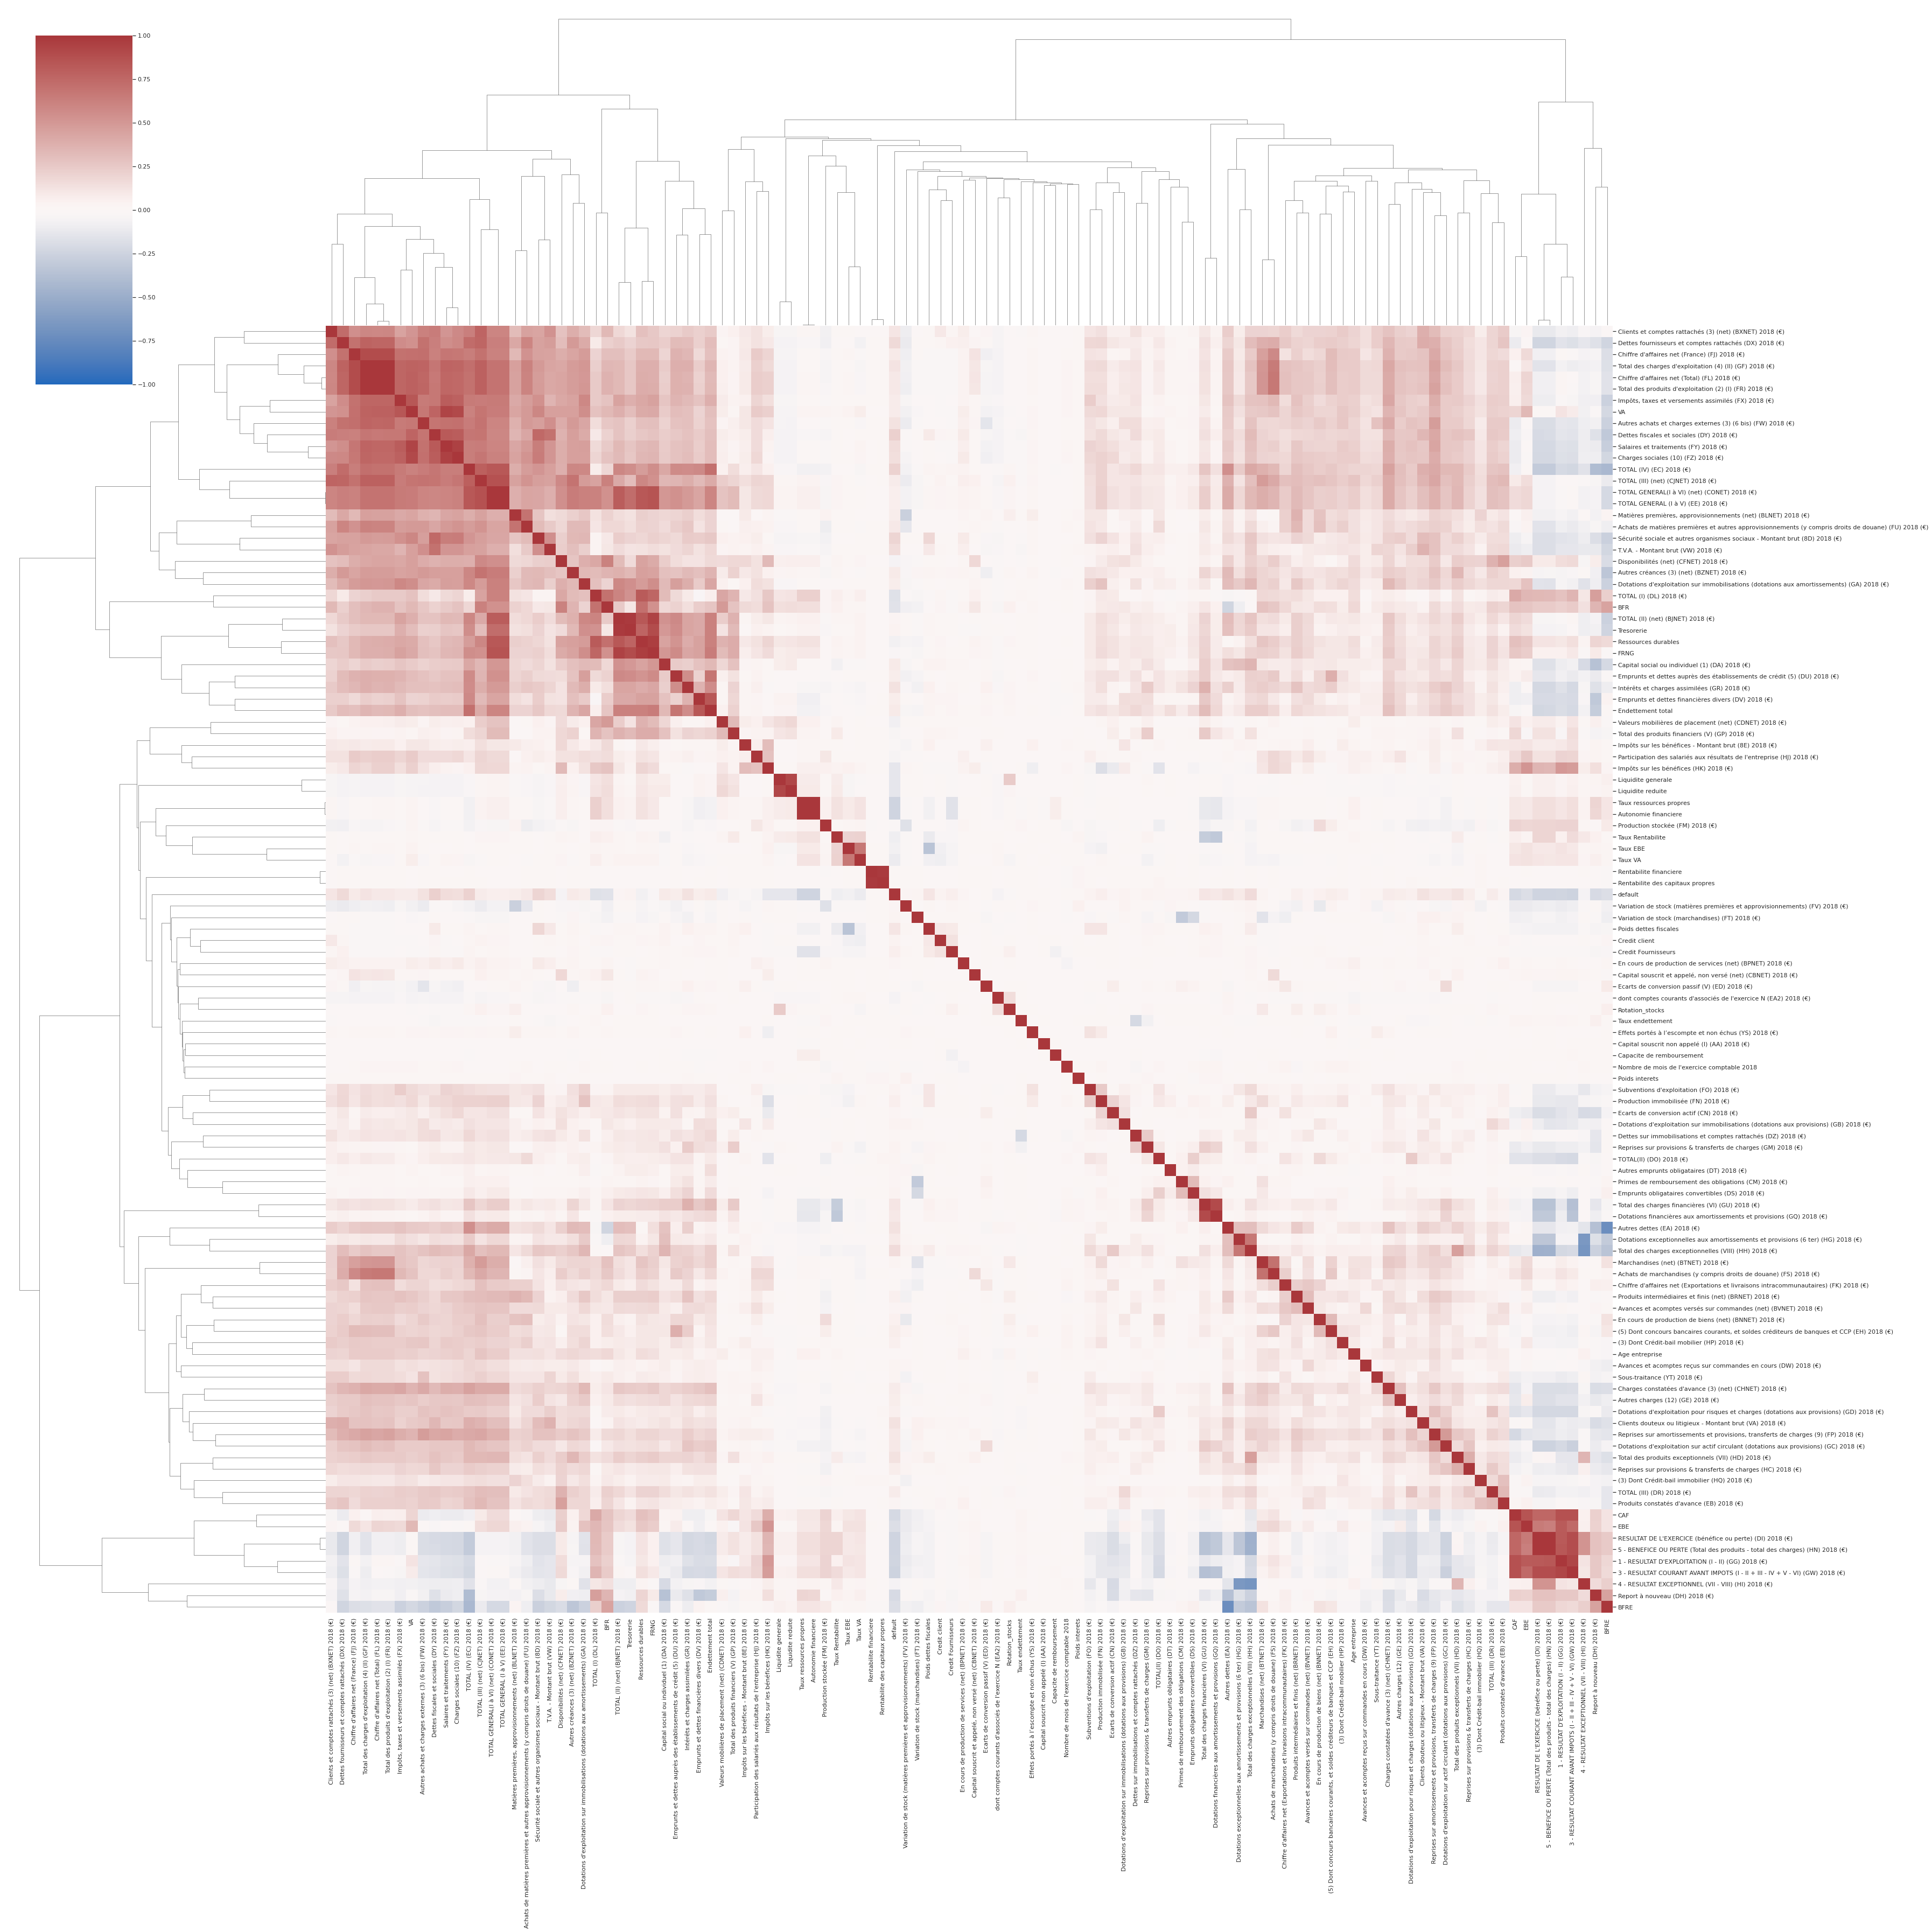

In [32]:
sns.clustermap(corr, figsize=(50,50), annot=False, cmap="vlag", vmin=-1, vmax=1)
plt.savefig("clustermap.png")